In [1]:
from fractions import Fraction
from functools import total_ordering

import numpy as np
import pylab as pl
from matplotlib import collections as mc
from sortedcontainers import SortedList


In [2]:
# If programming the algorithm from scratch is too difficult, you can use this skeleton.
# I tried to keep it as simple as possible; as a consequence degenerate cases will not be handled and the algorithm is not robust.
# As data structues for the Event queue and for the status, it uses SortedList.
# I have left some TODOs with question marks for you to fill in. Search for TODOs and add code there, according to what you have learned in the videos.


class Segment:
    def __init__(self, x1, y1, x2, y2, currentYList=None):
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.currentYList = currentYList  # stored in list to have it mutable

        if y1 == y2:
            raise Exception('Horizontal segments not supported.')
        if x1 == x2:
            raise Exception('Vertical segments not supported.')
        else:
            self.slope = (y2 - y1)/(x2-x1)
            self.intersept = y2 - self.slope*x2

    def currentX(self):
        return (self.currentYList[0] - self.intersept)/self.slope

    # TODO: when inserting into the status we need a comparison operator between segments. t
    # That is we need to implement "<" (that is __lt__) and "==" (that is __eq__).
    # What attribute(s) or method(s) do we need to call?
    # Below I filled in x1 (self.x1 < other.x1; self.x1 == other.x1), but that is certainly wrong
    # Change these two lines to make the comparison work correctly

    def __lt__(self, other):
        #
        return self.x1 < other.x1

    def __eq__(self, other):
        return self.x1 == other.x1

    def intersection(self, other):
        x1 = self.x1
        y1 = self.y1
        x2 = self.x2
        y2 = self.y2
        x = other.x1
        y = other.y1
        xB = other.x2
        yB = other.y2

        dx1 = x2 - x1
        dy1 = y2 - y1
        dx = xB - x
        dy = yB - y
        DET = (-dx1 * dy + dy1 * dx)

        # if math.fabs(DET) < DET_TOLERANCE: raise Exception('...')
        if DET == 0:
            raise Exception(
                'Intersection implementation not sufficiently robust for this input.')
        DETinv = Fraction(1, DET)

        r = Fraction((-dy * (x-x1) + dx * (y-y1)), DET)
        s = Fraction((-dy1 * (x-x1) + dx1 * (y-y1)), DET)

        if r < 0 or r > 1 or s < 0 or s > 1:
            return None

        # return the average of the two descriptions
        xi = x1 + r*dx1
        yi = y1 + r*dy1
        return (xi, yi)


class Event:
    class Type:
        INTERSECTION = 0
        START = 1
        END = 2

    def __init__(self, type, segment, segment2=None, ipoint=None):
        self.type = type
        self.segment = segment
        # segment2 = None for non-intersection events
        self.segment2 = segment2

        if type == 1:
            if segment.y1 < segment.y2 or (segment.y1 == segment.y2 and segment.x2 < segment.x1):
                self.key = (segment.y2, -segment.x2)
            else:
                self.key = (segment.y1, -segment.x1)

        elif type == 2:
            if segment.y1 > segment.y2 or (segment.y1 == segment.y2 and segment.x2 > segment.x1):
                self.key = (segment.y2, -segment.x2)
            else:
                self.key = (segment.y1, -segment.x1)

        elif type == 0:
            # compute intersection point
            # self.key = (segment.intersection(segment2)[1], -segment.intersection(segment2)[0])
            self.key = (ipoint[1], -ipoint[0])


def checkIntersection(pos, pos2, Events, Status):
    segment = Status[pos]
    segment2 = Status[pos2]
    ipoint = segment.intersection(segment2)
    if ipoint and ipoint[1] < segment.currentYList[0]:
        ievent = Event(0, segment, segment2, ipoint)
        index = Events.bisect_left(ievent)
        # for simplicity we assume general position:
        if index == len(Events) or not Events[index].key == (ipoint[1], -ipoint[0]):
            Events.add(ievent)


def handleStartEvent(segment, Events, Status):
    # print("Inserting", segment.x1, segment.y1, segment.x2, segment.y2)
    # TODO: Implement EventHandling for the upper endpoint of a segment
    # If you don't know where to start, you can look at the event handling for intersection events
    print("Code is missing here.")


def handleEndEvent(segment, Events, Status):
    # print("Removing", segment.x1, segment.y1, segment.x2, segment.y2)
    # TODO: Implement EventHandling for the upper endpoint of a segment
    # If you don't know where to start, you can look at the event handling for intersection events
    print("Code is missing here.")


def handleIntersectionEvent(segment, segment2, Events, Status):
    currentY = segment.currentYList[0]
    # we need to make sure that the comparison operator is consistent with the order just before the event
    segment.currentYList[0] = currentY + 0.00001

    # print("Handling intersection", segment.x1, segment.y1, segment.x2, segment.y2, segment2.x1, segment2.y1, segment2.x2, segment2.y2)

    # swapping is not implemented for SortedList, so we need a trick here
    pos = Status.index(segment)
    pos2 = Status.index(segment2)
    # Status[pos] = segment2
    # Status[pos2] = segment
    # instead we can remove and reinsert one of the segments.
    Status.remove(segment)
    segment.currentYList[0] = currentY - 0.00001
    Status.add(segment)

    pos_first = min(pos, pos2)

    if pos_first > 0:
        checkIntersection(pos_first-1, pos_first, Events, Status)
    if pos_first + 2 < len(Status):
        checkIntersection(pos_first+1, pos_first+2, Events, Status)

    segment.currentYList[0] = currentY


def sweep(inputSegments):
    EndpointEvents = []
    for s in inputSegments:
        EndpointEvents.append(Event(1, s))
        EndpointEvents.append(Event(2, s))

    Events = SortedList(EndpointEvents, key=lambda x: x.key)
    Status = SortedList()
    # Status = SortedList(key=Segment.currentX) This wouldn't work since keys are cached

    nEvents = 0
    nIntersections = 0

    currentYList = inputSegments[0].currentYList
    lines = []

    while Events:
        e = Events.pop()
        nEvents += 1
        currentYList[0] = e.key[0]

        if nEvents in [3, 17, 99]:
            print("Event", nEvents, ":", e.type)

        if e.type == 1:
            handleStartEvent(e.segment, Events, Status)
            lines.append([[e.segment.x1, e.segment.y1],
                         [e.segment.x2, e.segment.y2]])

        elif e.type == 2:
            handleEndEvent(e.segment, Events, Status)
            # lines.remove([[e.segment.x1,e.segment.y1],[e.segment.x2,e.segment.y2]])

        else:
            nIntersections += 1
            handleIntersectionEvent(e.segment, e.segment2, Events, Status)

        # Can be useful for debugging
        # print("Status:")
        # for s in Status: print(s.x1, s.y1, s.x2, s.y2, s.currentX())
        # lc = mc.LineCollection(lines, linewidths=2)
        # fig, ax = pl.subplots()
        # ax.add_collection(lc)
        # ax.autoscale()
        # ax.margins(0.1)

    print("Number of events:", nEvents)
    print("Number of intersections:", nIntersections)


In [3]:
def readSegments(file):
    currentYList = [0]
    segments = []
    with open(file) as f:
        for line in f:
            coord = [int(x) for x in line.split()]
            s = Segment(coord[0], coord[1], coord[2], coord[3], currentYList)
            segments.append(s)

    return segments


# TODO: change this to the filename where your segments are stored.
input = readSegments("LineSegments.txt")
sweep(input)


Code is missing here.
Code is missing here.
Event 3 : 1
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Event 17 : 1
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is missing here.
Code is

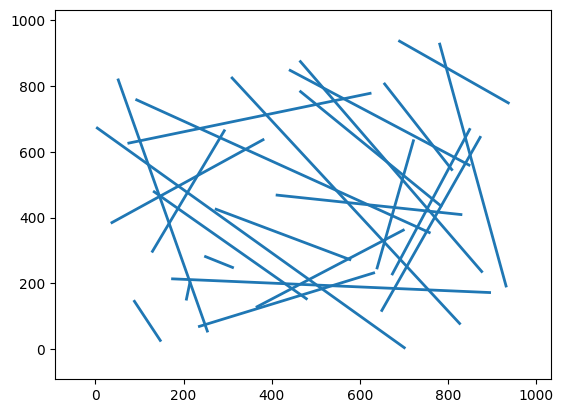

In [4]:
lines = [[(ls.x1, ls.x2), (ls.x2, ls.y2)] for ls in input]
# c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])

lc = mc.LineCollection(lines, linewidths=2)
fig, ax = pl.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
